# スタッキング(stacking)

- 複数段階に分けて学習と予測をする
- それぞれのデータの予測に使用するモデルは、そのデータを使って学習していない必要がある
- CVで学習をし、それぞれのfoldの予測をそれ以外のfoldで学習したモデルを使って行う


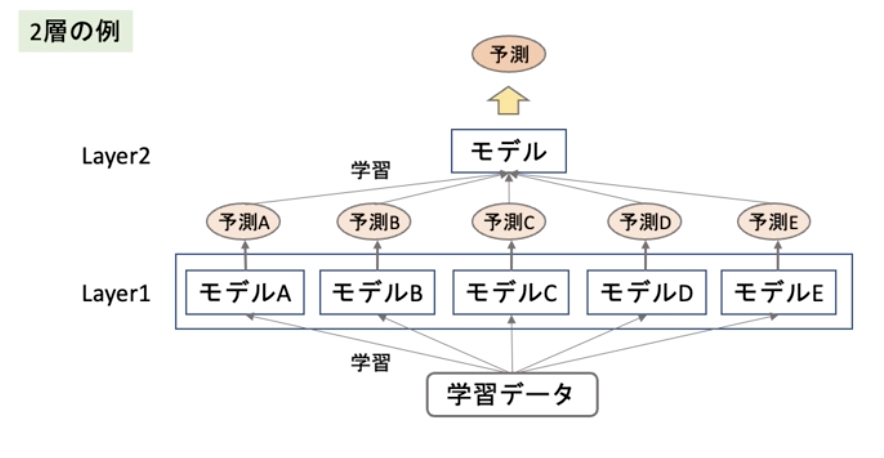